<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Asset_Allocation_Efficient_Frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

## Asset Allocation 
Evaluating the performance of a basic 1/n portfolio

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)
!pip install pyfolio
import pyfolio as pf


[*********************100%***********************]  8 of 8 completed
Downloaded 505 rows of data.


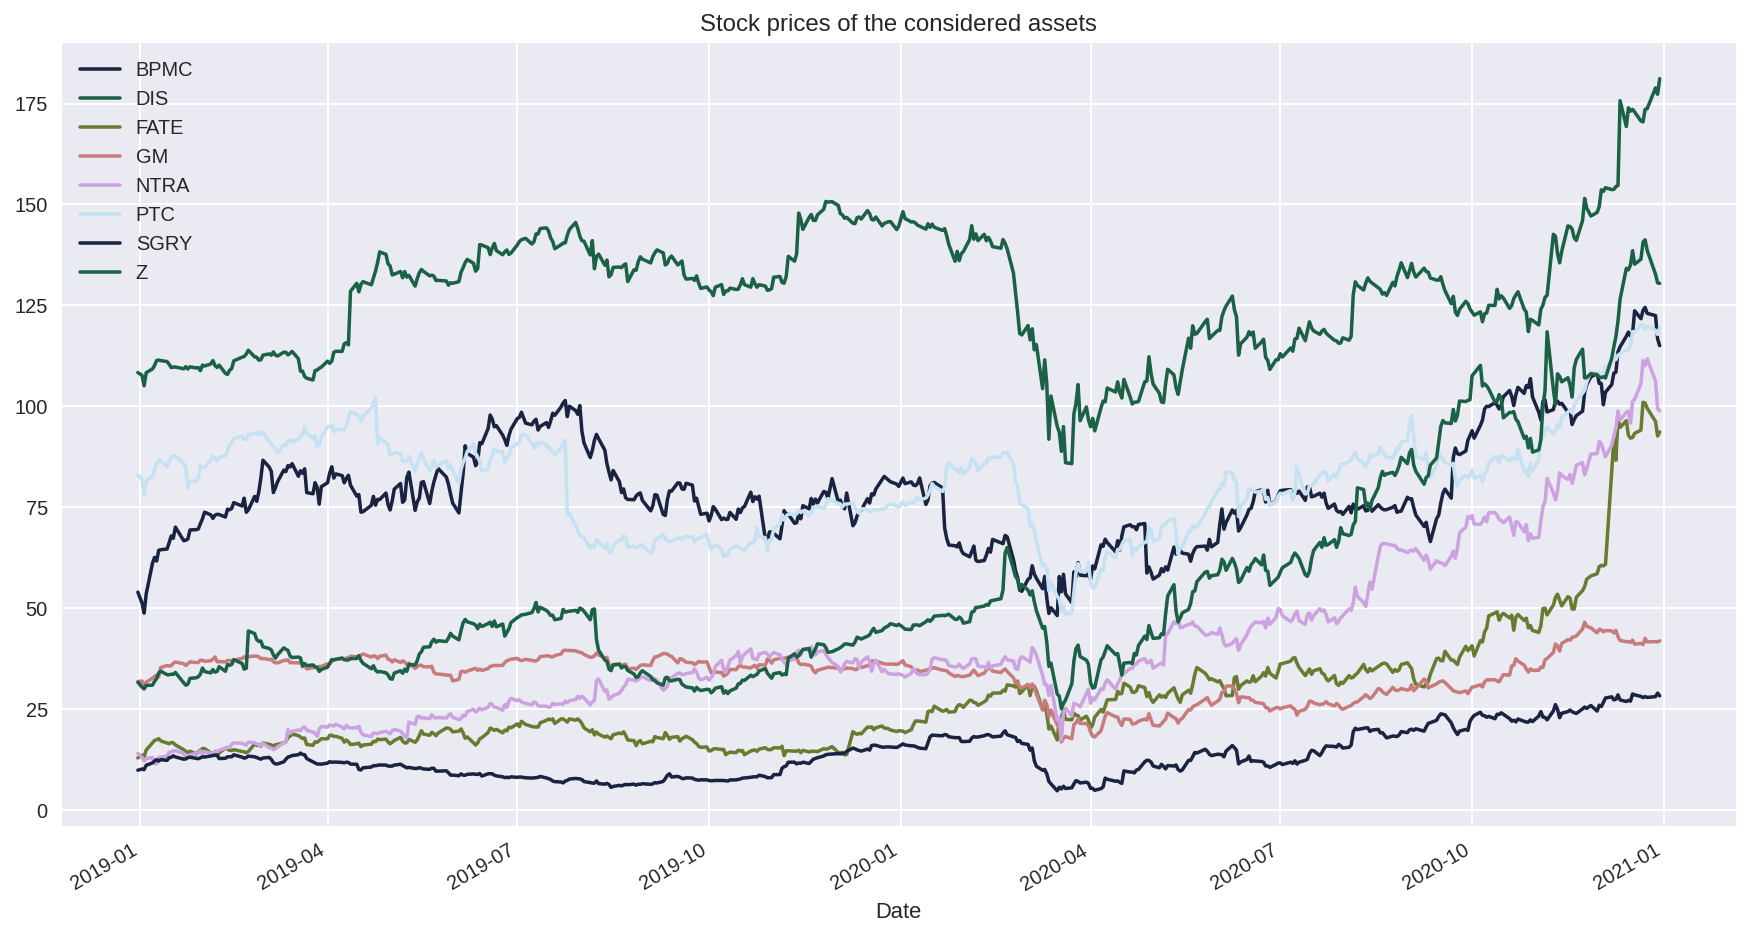

In [3]:
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
start = dt.datetime(2018,12,31)
end = dt.datetime(2020,12,31) # dt.datetime.now()
n_assets = len(tickers)

prices = yf.download(tickers, start=start, 
                        end=end, adjusted=True,
                     index_col='Date',
                  parse_dates=True)
print(f'Downloaded {prices.shape[0]} rows of data.')
prices['Adj Close'].plot(title='Stock prices of the considered assets', figsize = (15,8))
plt.show()

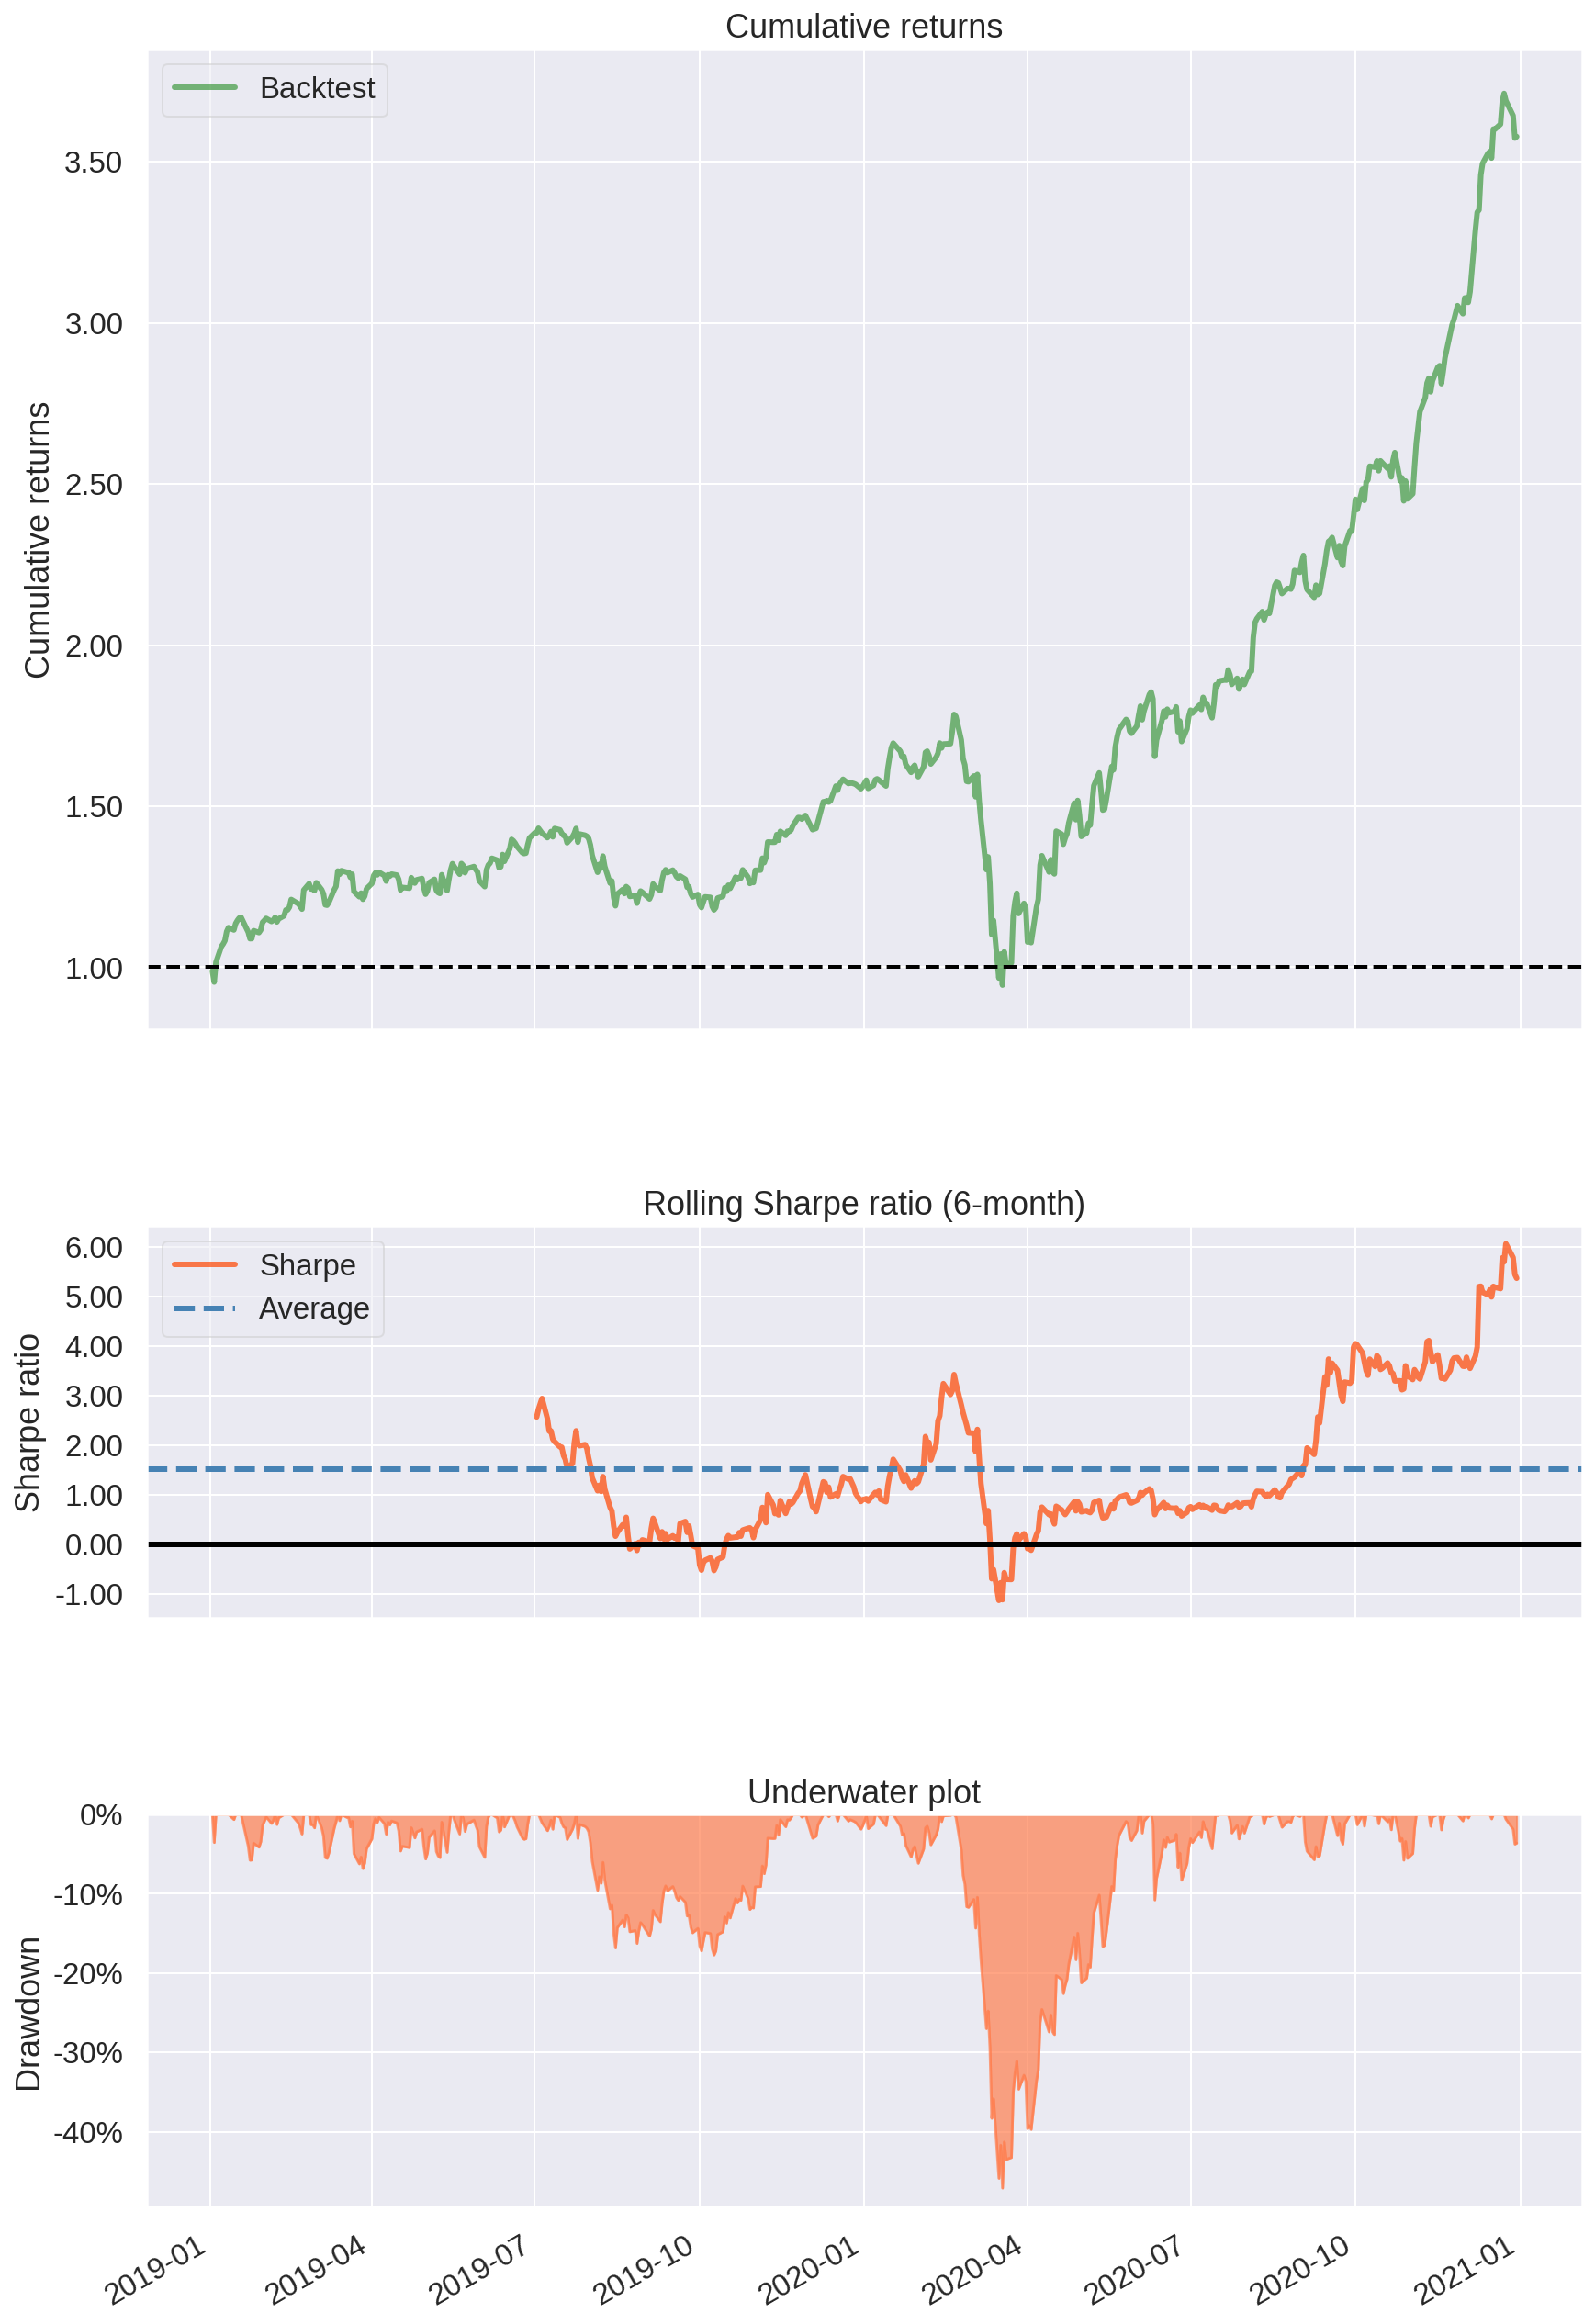

In [4]:
import numpy as np

# returns
returns = prices['Adj Close'].pct_change().dropna()

# weights
portfolio_weights = n_assets * [1 / n_assets]

# portfolio return
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), 
                              index=returns.index)

# simple tear sheet
pf.create_simple_tear_sheet(portfolio_returns)

In [ ]:
# remove your installed pyfolio library
!pip uninstall pyfolio

# Install it again from its github repo
!pip install git+https://github.com/quantopian/pyfolio

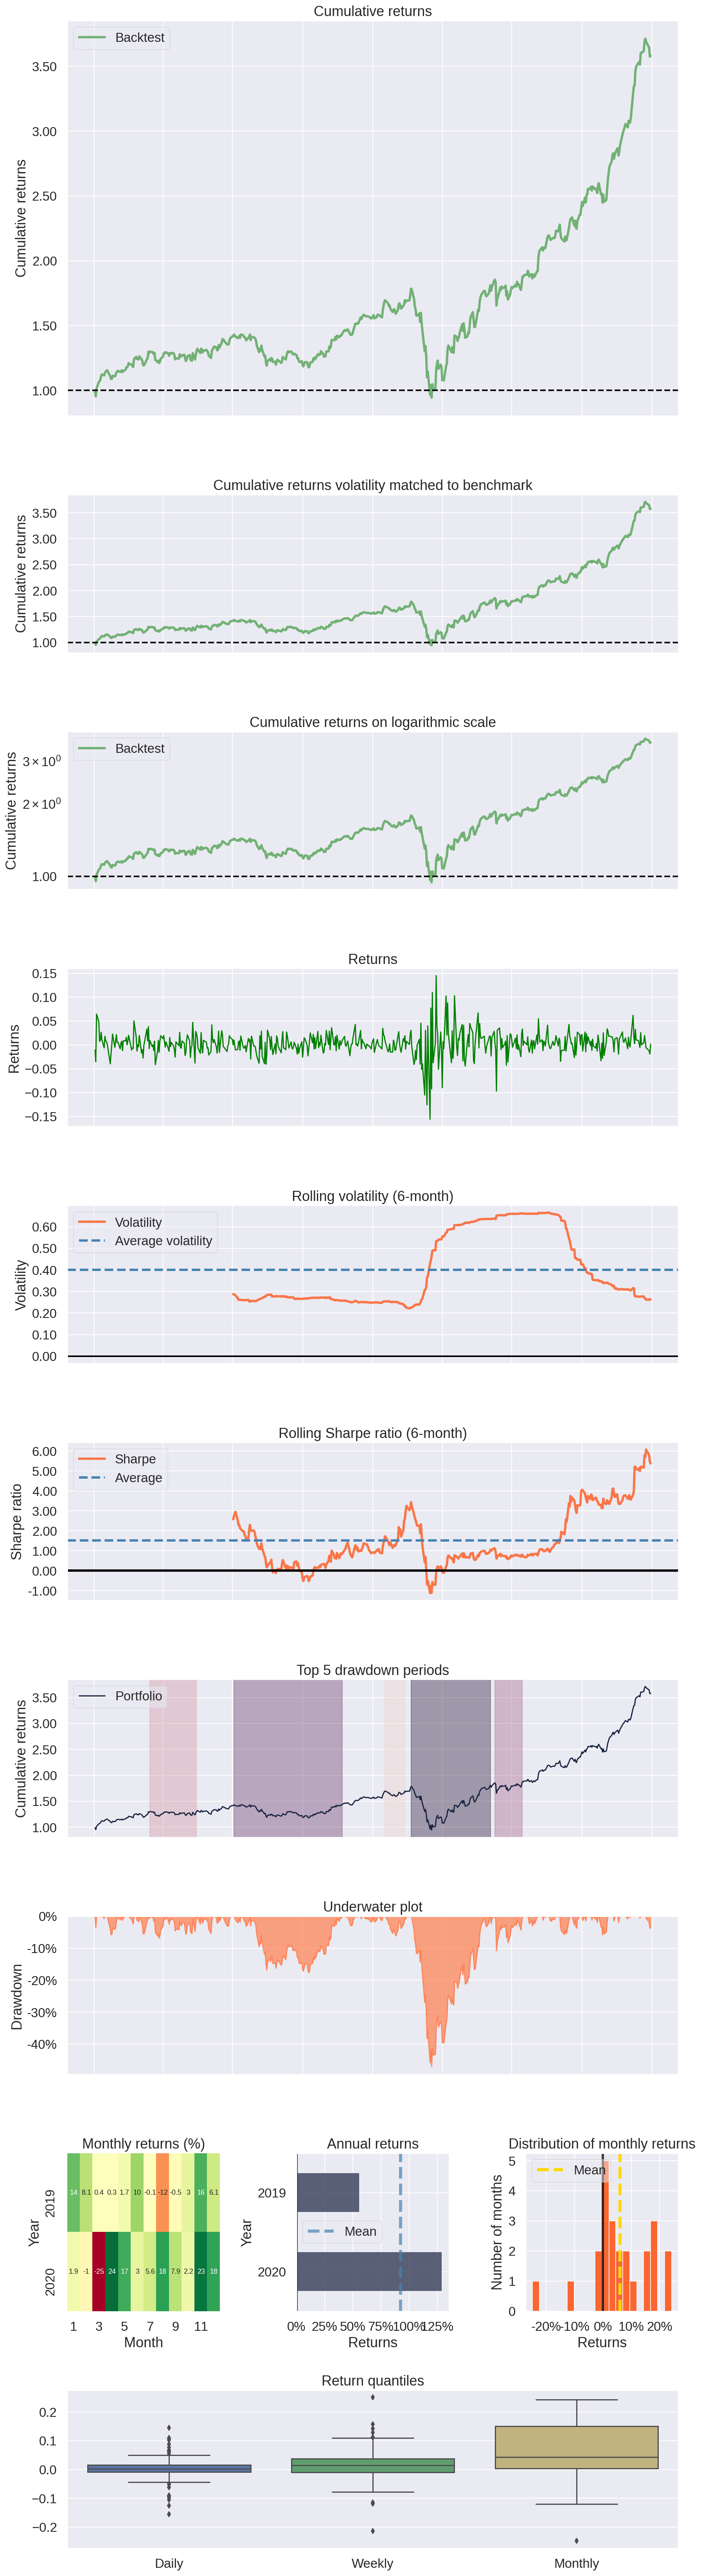

In [6]:
import pyfolio as pf
pf.create_returns_tear_sheet(portfolio_returns)

## Efficient Frontier using Monte Carlo simulations

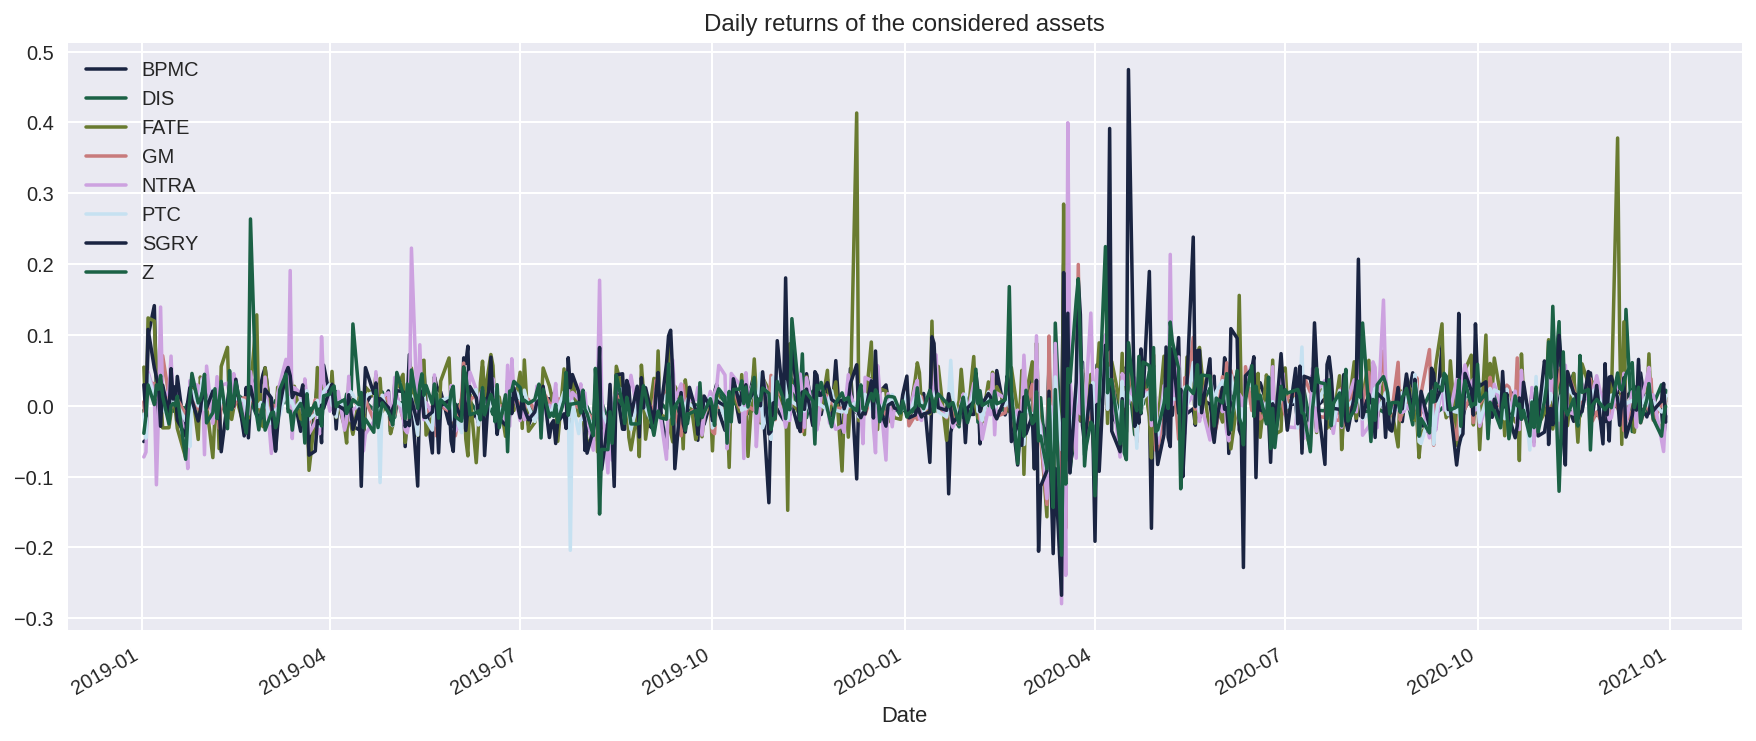

In [7]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252

returns = prices['Adj Close'].pct_change().dropna()
avg_returns = returns.mean() * N_DAYS
cov_mat = returns.cov() * N_DAYS

returns.plot(title='Daily returns of the considered assets', figsize = (15,6));

In [8]:
# simulation random portfolio returns
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

# portfolio metric
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

# joit dataframe
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio}).dropna()

IndexError: ignored

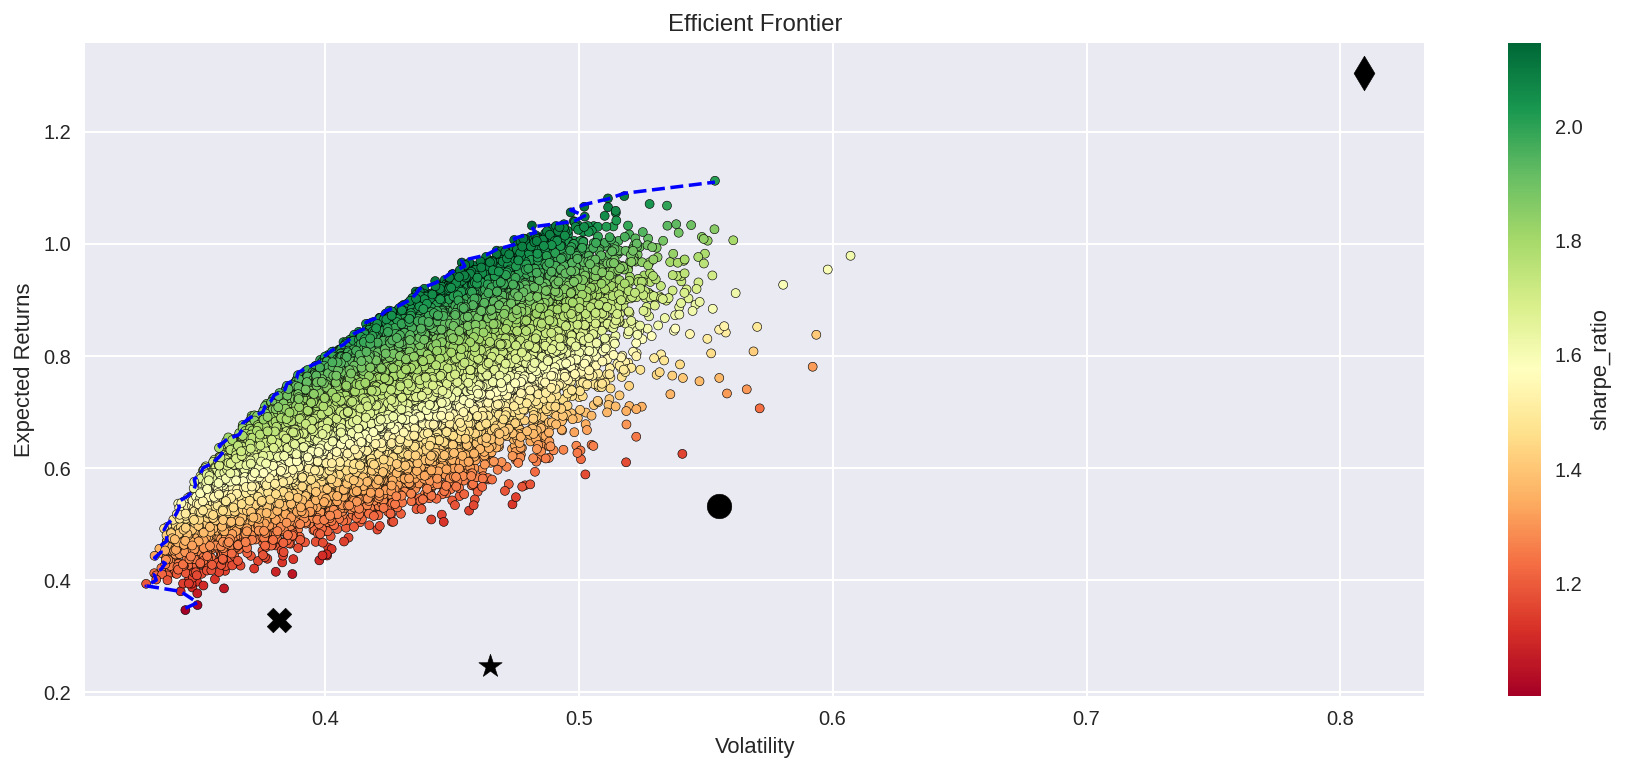

In [20]:
# Locate the points creating the Efficient Frontier:

N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

# Plot the Efficient Frontier:

MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots(figsize=(15,6))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=tickers[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]


print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(tickers, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 103.26% volatility: 48.16% sharpe_ratio: 214.43% 
Weights
SGRY: 6.31% NTRA: 7.68% Z: 27.47% FATE: 0.40% DIS: 27.72% GM: 1.20% BPMC: 2.91% PTC: 26.32% 

In [11]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(tickers, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 39.36% volatility: 32.96% sharpe_ratio: 119.41% 
Weights
SGRY: 16.70% NTRA: 30.53% Z: 1.55% FATE: 6.69% DIS: 3.56% GM: 38.93% BPMC: 1.07% PTC: 0.98% 

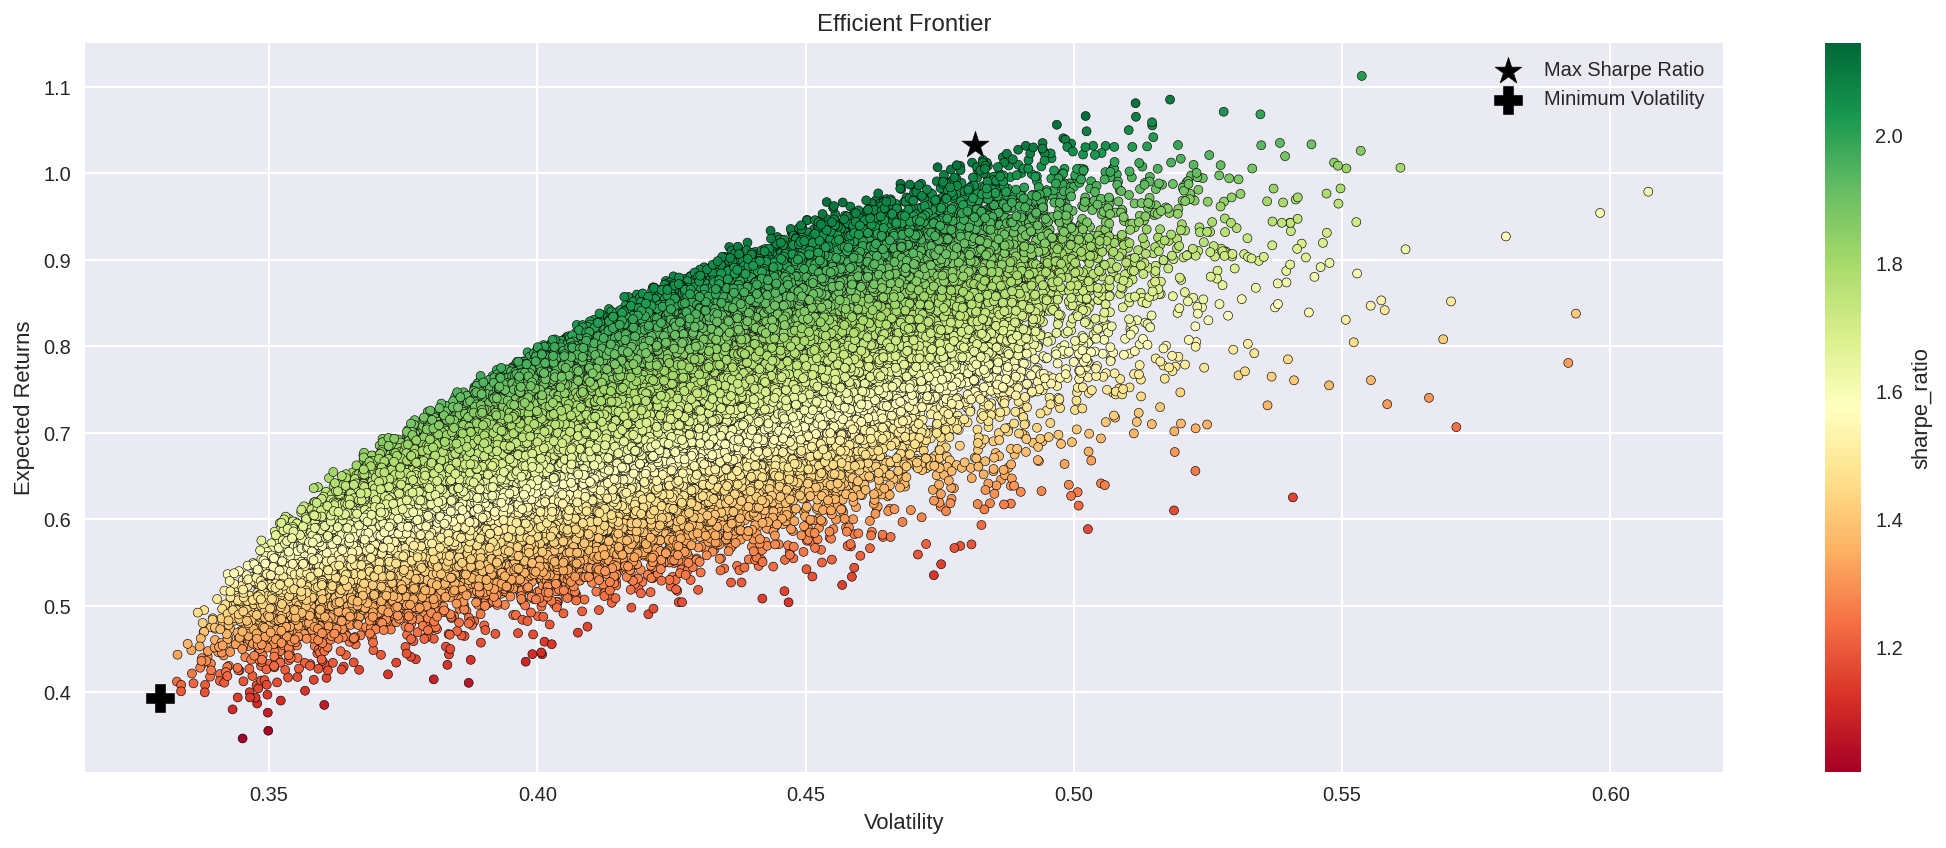

In [12]:
fig, ax = plt.subplots(figsize = (15,6))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

## Efficient Frontier using optimization with scipy

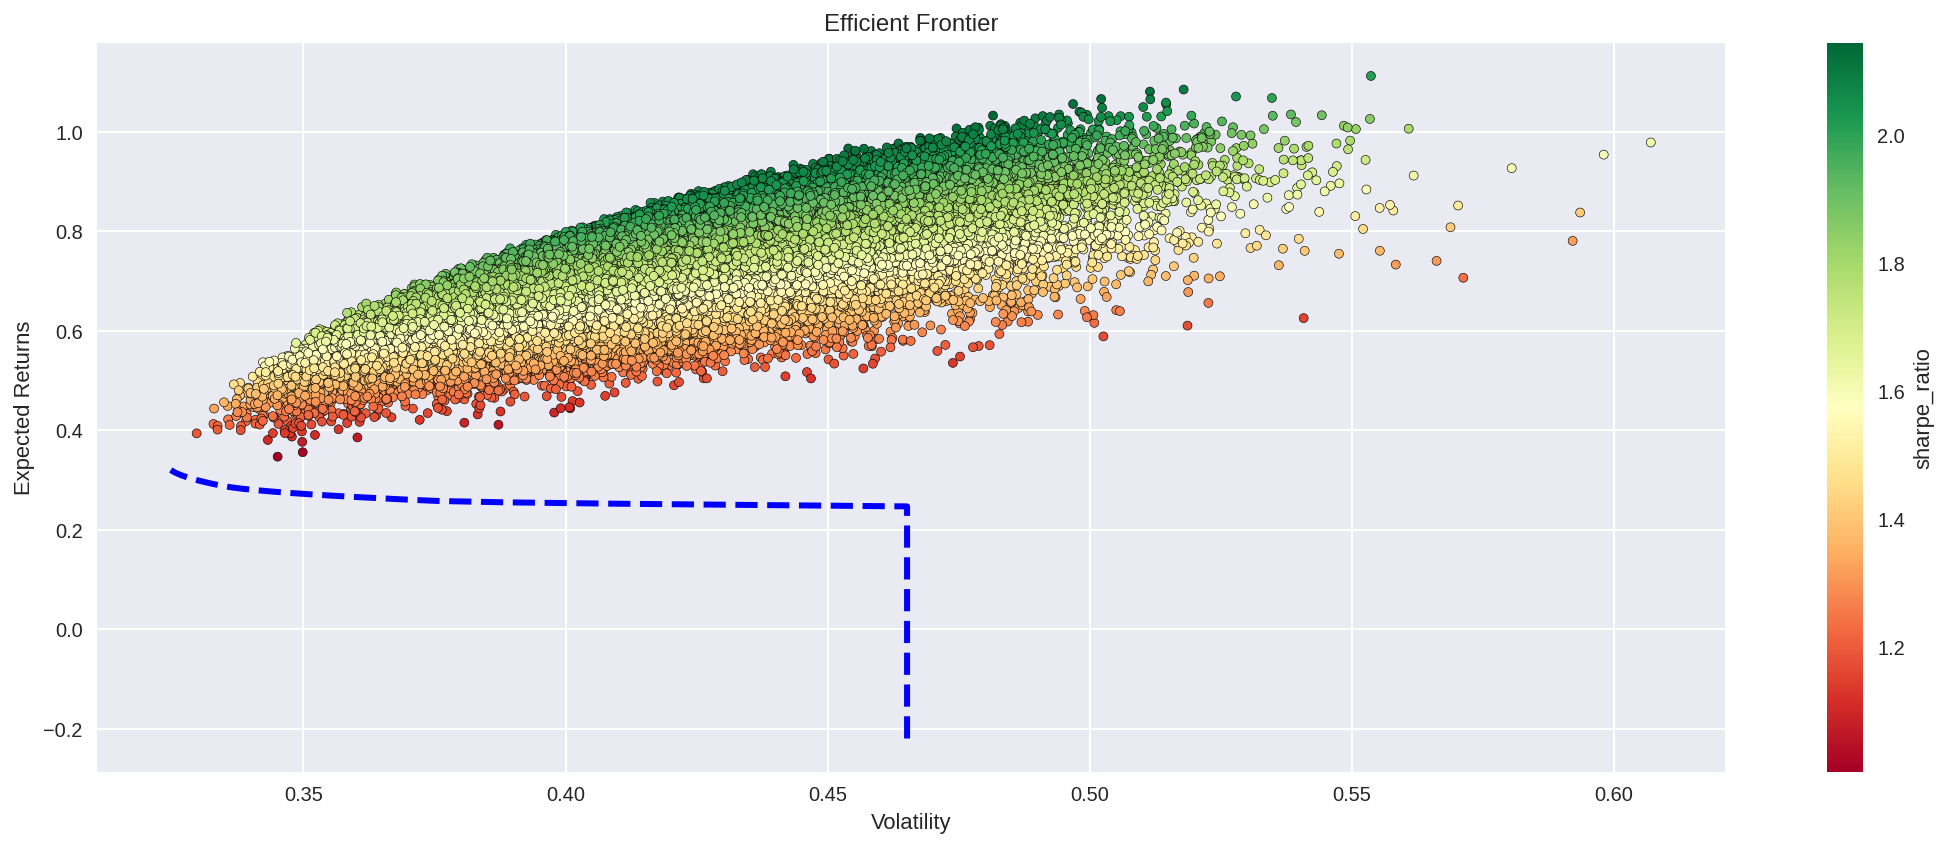

In [13]:
import numpy as np
import scipy.optimize as sco

# functions calculating portfolio returns and volatility:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

# function calculating the efficient frontier:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

# Define the considered range of returns:
rtns_range = np.linspace(-0.22, 0.32, 200)

# Calculate the Efficient Frontier:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

# Extract the volatilities of the efficient portfolios:
vols_range = [x['fun'] for x in efficient_portfolios]

# Plot the calculated Efficient Frontier, together with the simulated portfolios:

fig, ax = plt.subplots(figsize = (15,6))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

plt.tight_layout()
plt.show()

In [14]:
# minimum volatility portfolio:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': 0.32,
 'Sharpe Ratio': 0.9855630721966419,
 'Volatility': 0.32468748984961243}

In [15]:
# performance summary:

print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(tickers, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 32.00% Volatility: 32.47% Sharpe Ratio: 98.56% 
Weights
SGRY: 10.57% NTRA: 42.85% Z: 0.00% FATE: 10.39% DIS: 0.00% GM: 36.19% BPMC: 0.00% PTC: 0.00% 

In [16]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

# optimized portfolio:
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

# Extract information about the maximum Sharpe Ratio portfolio:

max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 1.158761447746222,
 'Sharpe Ratio': 2.1710088653809603,
 'Volatility': 0.5337433053470683}

In [17]:
# performance summary:

print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(tickers, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 115.88% Volatility: 53.37% Sharpe Ratio: 217.10% 
Weights
SGRY: 0.00% NTRA: 0.00% Z: 32.05% FATE: 0.00% DIS: 36.44% GM: 0.00% BPMC: 4.31% PTC: 27.20% 

## Efficient Frontier using convex optimization with cvxpy

In [ ]:
pip install cvxpy

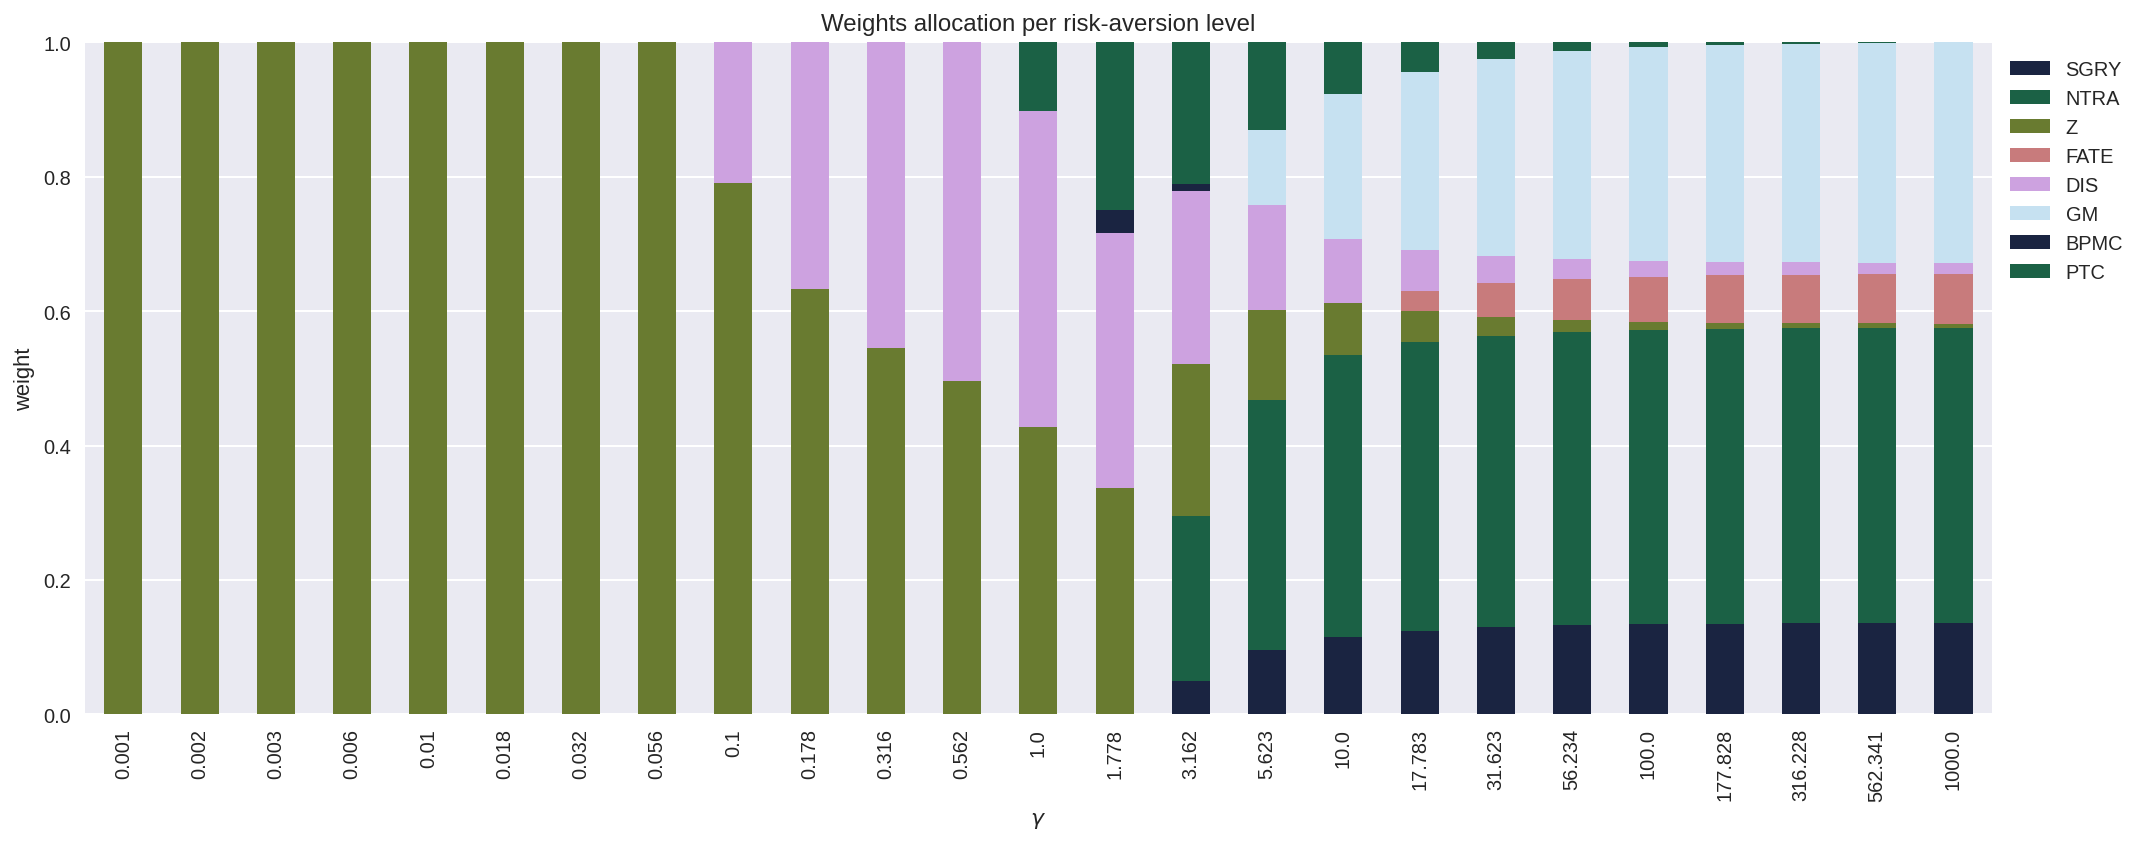

In [22]:
import cvxpy as cp

# Convert the annualized average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

# Set up the optimization problem:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns * weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

# Calculate the Efficient Frontier:

N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

# Plot the allocation for different values of the risk-aversion parameter:
weights_df = pd.DataFrame(weights_ef, 
                          columns=tickers, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True, figsize = (15,6)) 
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$', 
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

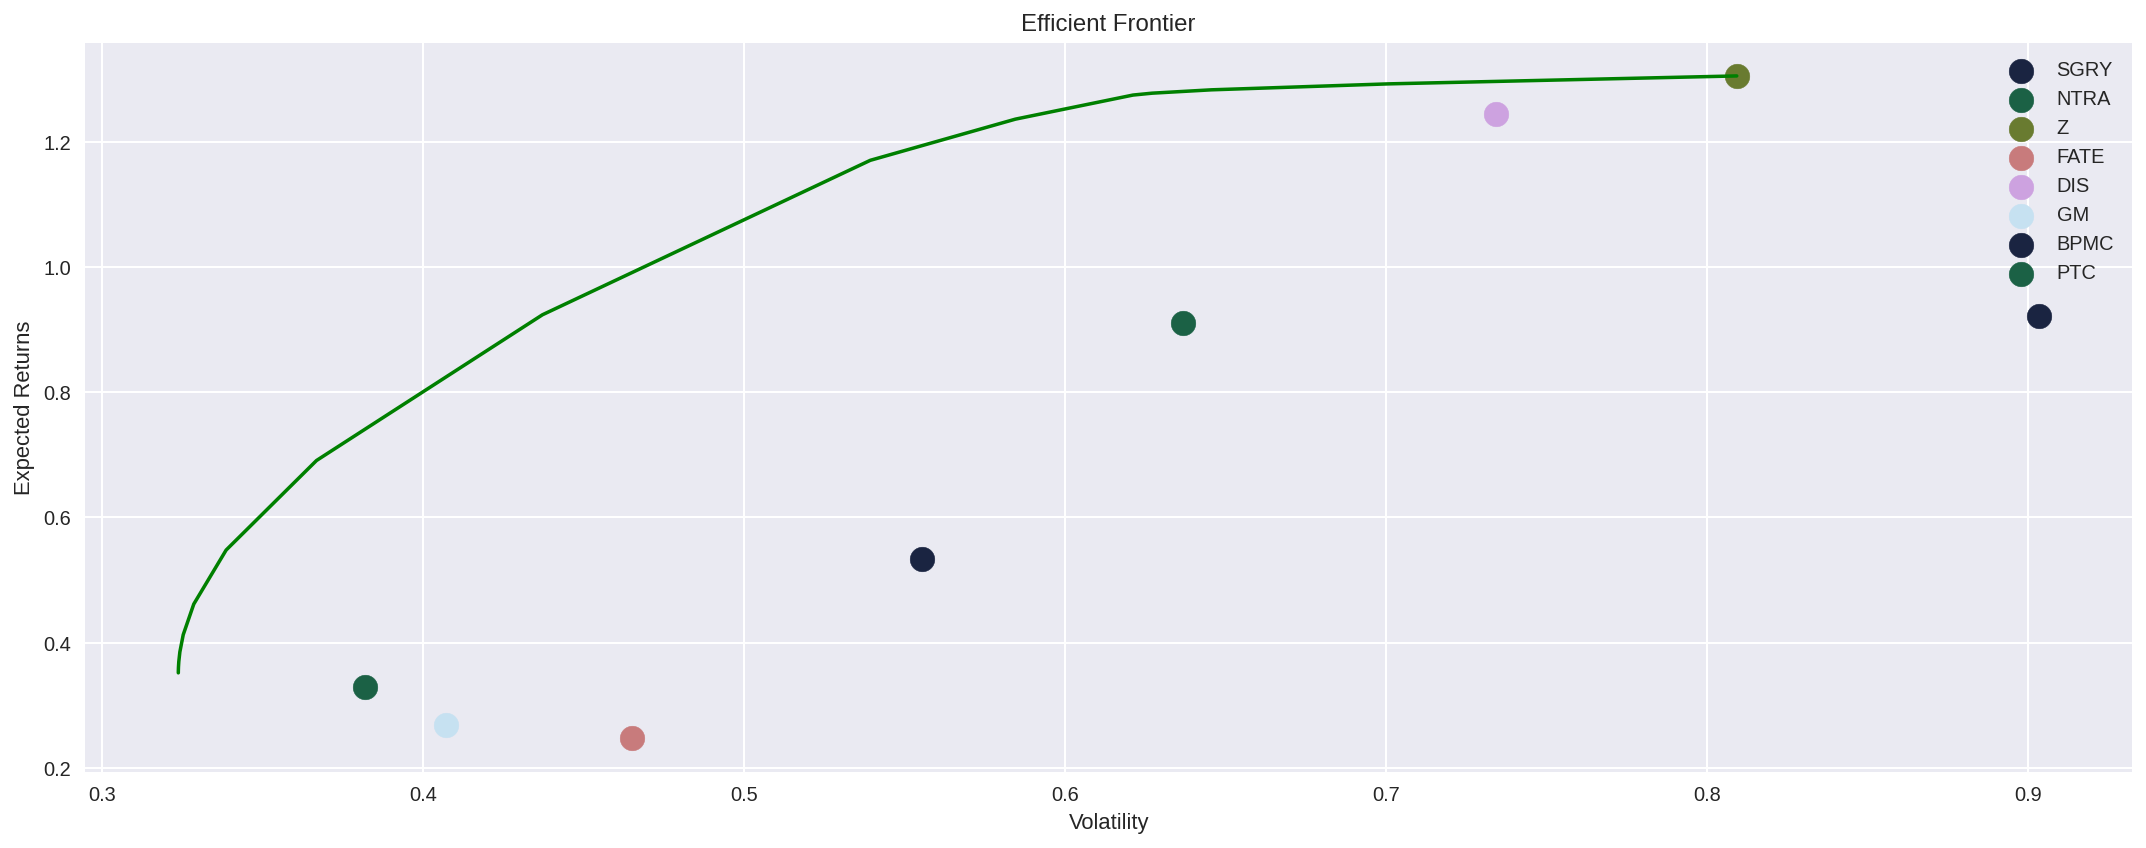

In [23]:
# Plot the Efficient Frontier, together with the individual assets:
#MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots(figsize = (15,6))
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                #  marker=MARKS[asset_index], 
                 label=tickers[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility', 
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()
plt.show()

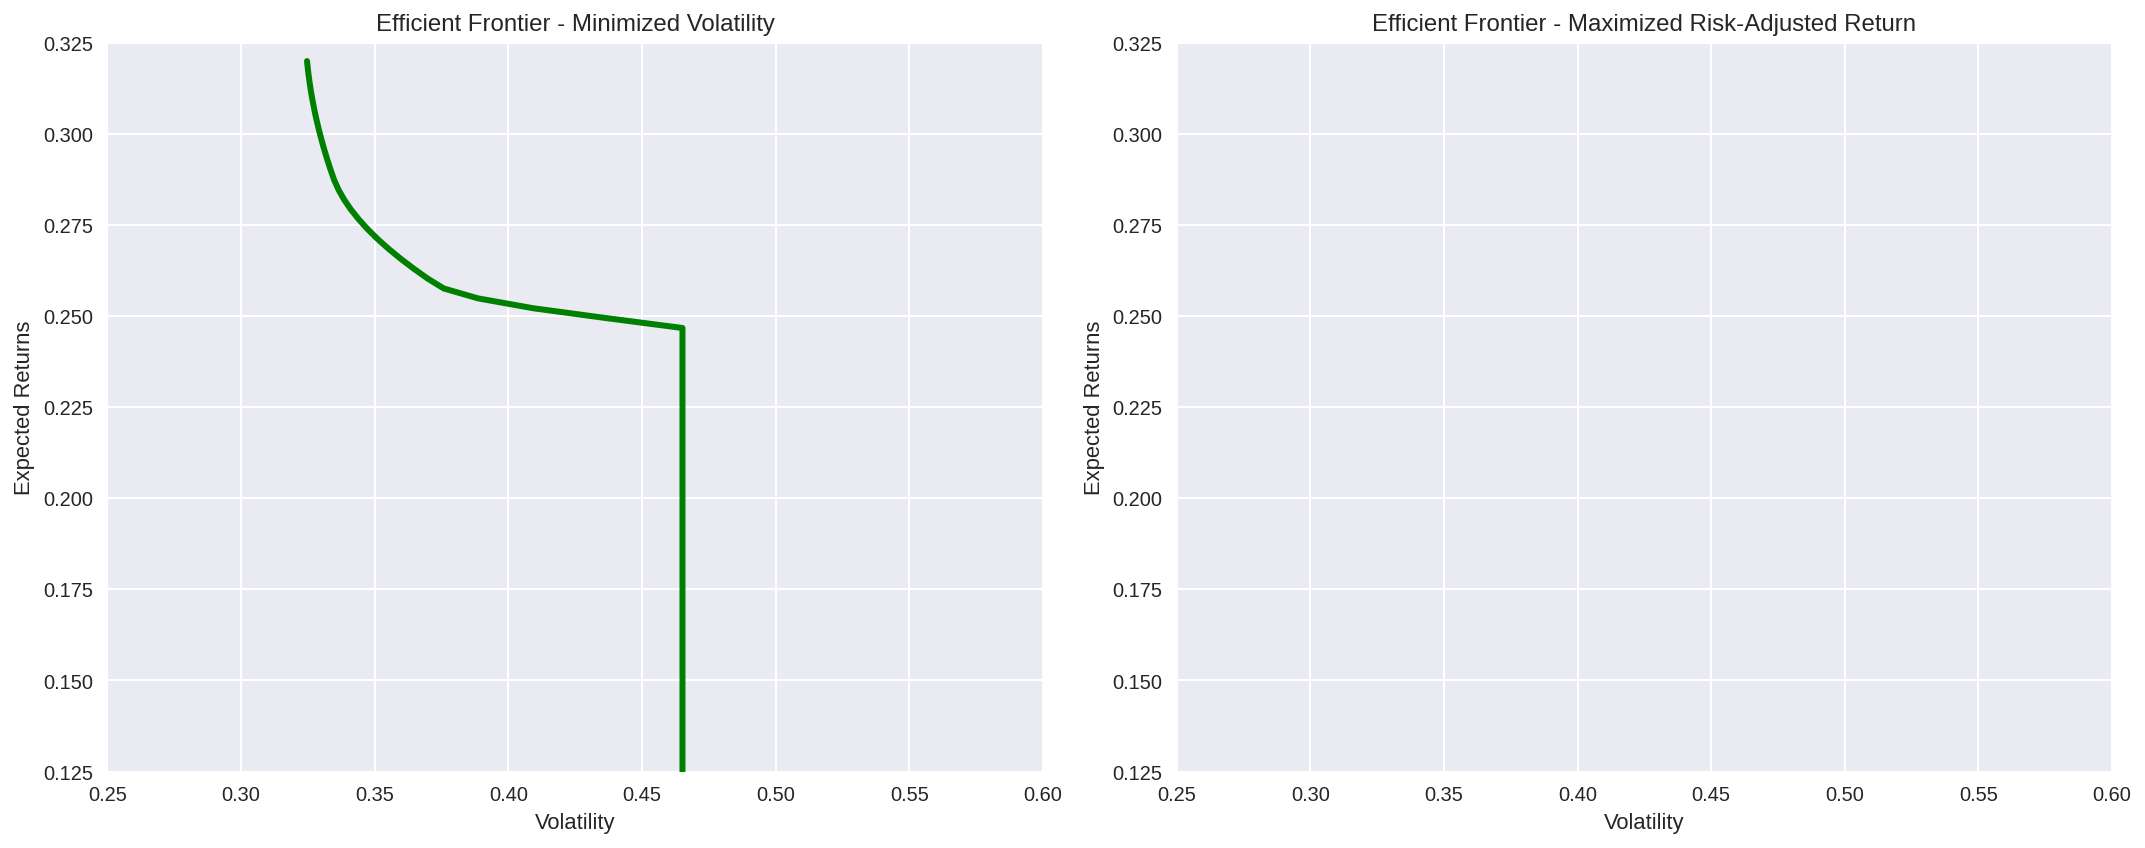

In [29]:
x_lim = [0.25, 0.6]
y_lim = [0.125, 0.325]

fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Efficient Frontier - Minimized Volatility',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Efficient Frontier - Maximized Risk-Adjusted Return',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

plt.tight_layout()
plt.show()

----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 114, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 17, constraints m = 28
Cones:	primal zero / dual free vars: 1
	linear vars: 17
	soc vars: 10, soc blks: 1
Setup time: 6.83e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.87e+19  6.46e+18  1.00e+00 -1.45e+19  7.99e+18  7.44e+19  1.88e-03 
   100| 1.83e-06  6.02e-06  1.83e-06 -1.30e+00 -1.30e+00  1.74e-16  1.76e-02 
-------------------------------------------

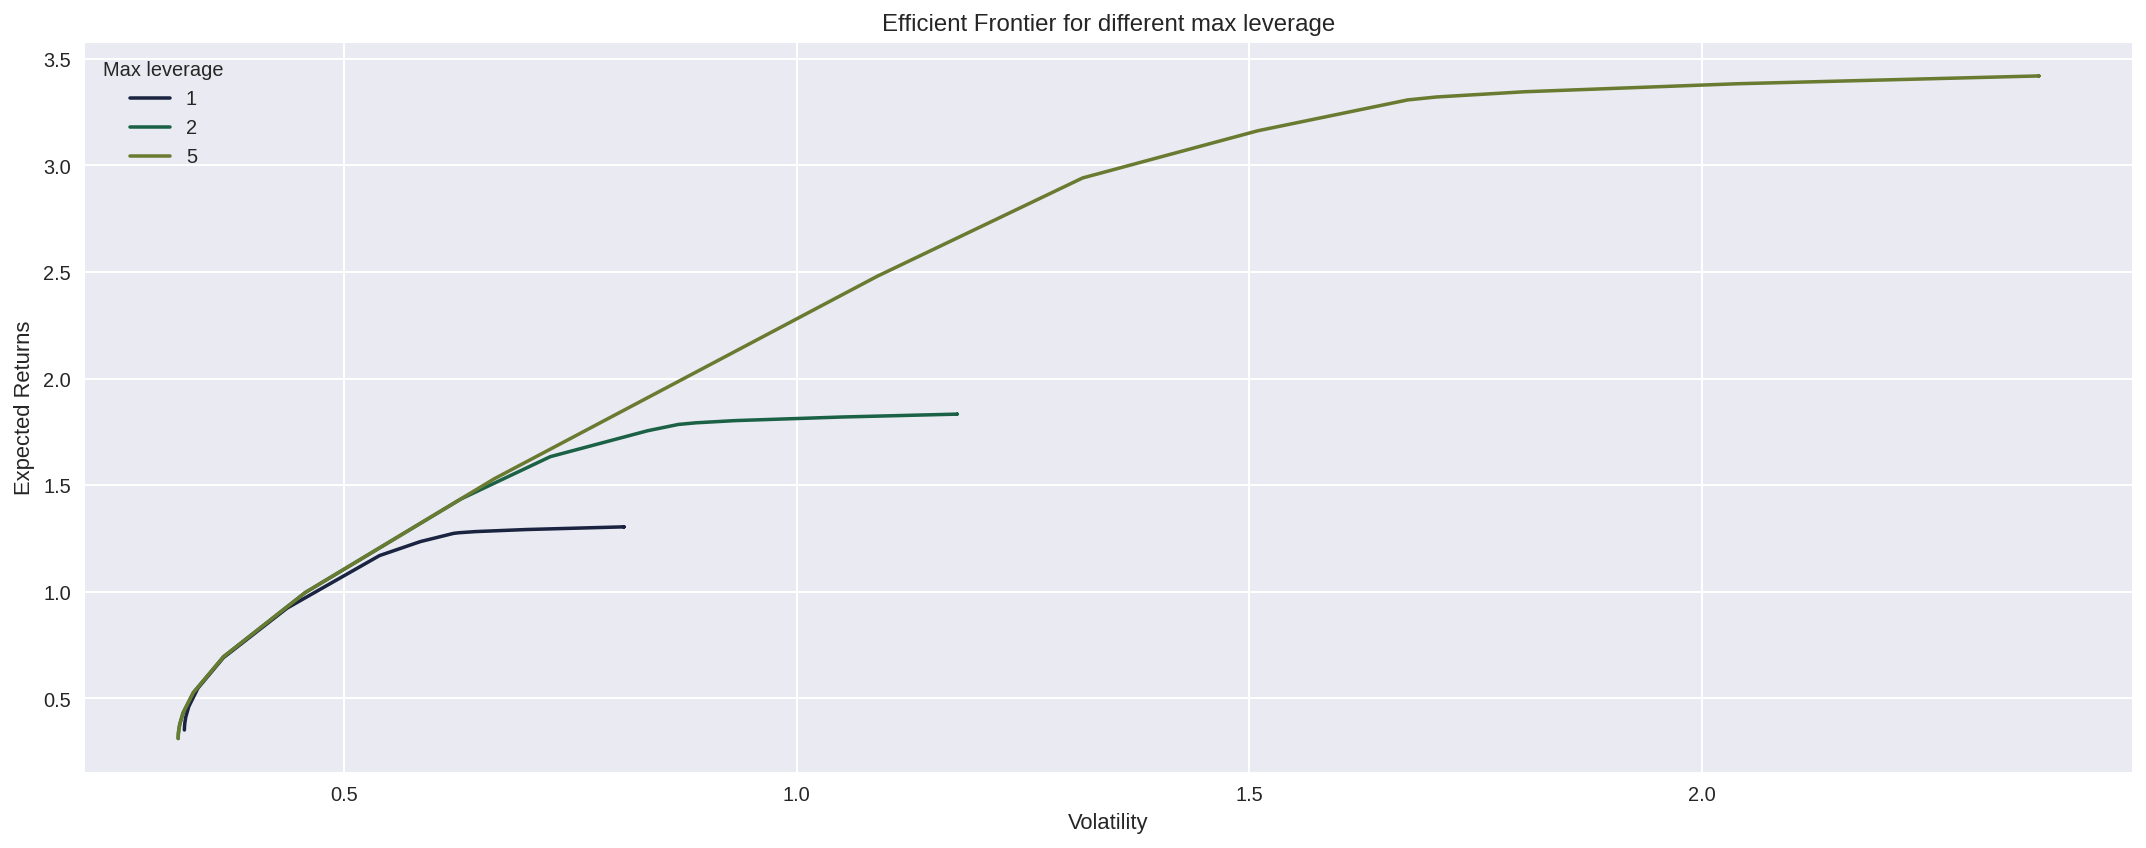

In [36]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function, 
                                   [cp.sum(weights) == 1, 
                                    cp.norm(weights, 1) <= max_leverage])


LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve(solver=cp.SCS, verbose=True, use_indirect=True)
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

fig, ax = plt.subplots(figsize = (15,6))

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l_ef[:, leverage_index], 
             portf_rtn_l_ef[:, leverage_index], 
             label=f'{leverage}')

ax.set(title='Efficient Frontier for different max leverage',
       xlabel='Volatility', 
       ylabel='Expected Returns')
ax.legend(title='Max leverage')

plt.tight_layout()
plt.show()

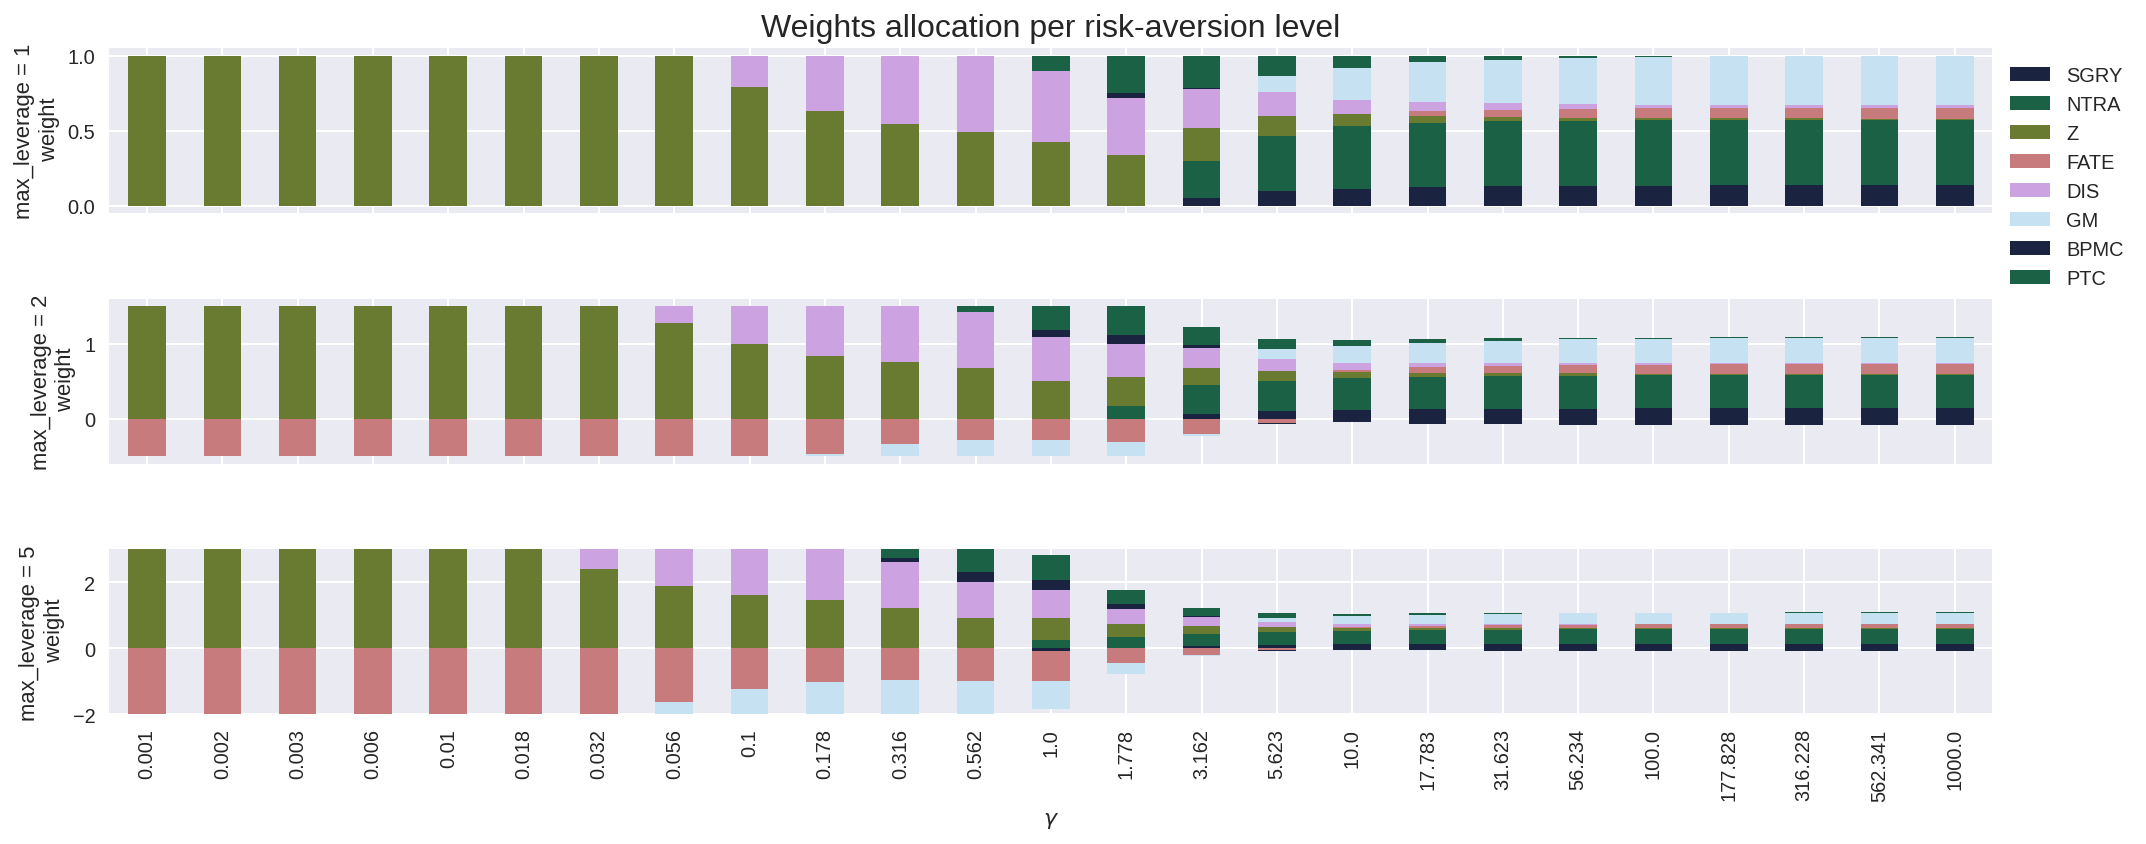

In [37]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True, figsize = (15,6))

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=tickers, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar', 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(ylabel=(f'max_leverage = {LEVERAGE_RANGE[ax_index]}' 
                             '\n weight'))

    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)

plt.tight_layout()
plt.show()